## Human Edit Action Agent
Agent base chatbot using Amazon Bedrock and LangGraph.

Human can edit the actions.

In [1]:
import boto3
import json
import logging

from langchain_aws import ChatBedrock
from langchain_core.output_parsers import StrOutputParser

boto3.set_stream_logger('', logging.ERROR)

# Initialize AWS Bedrock client
bedrock_client = boto3.client(
    service_name='bedrock-runtime'
    ,region_name='ap-southeast-2'
)

llm = ChatBedrock(
    client=bedrock_client,
    model_id="amazon.nova-pro-v1:0",  
    model_kwargs={
        "temperature": 0.3,  # Same temperature as original
        "maxTokenCount": 1000
    }
)

In [2]:
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

from typing_extensions import TypedDict
from typing import Annotated

In [3]:
%load_ext dotenv
%dotenv ../../.env

In [4]:
from langchain_community.tools import TavilySearchResults
travily_search = TavilySearchResults(max_results=2)

/var/folders/8w/ytv2_9yd0nld4gbqjwbs4yw40000gn/T/ipykernel_97912/731925779.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  travily_search = TavilySearchResults(max_results=2)


In [5]:
# current date and time
import datetime
from langchain_core.tools import tool

@tool
def get_current_date():
    """
    Get the current date and time.
    Use this tool first for any tile-based queries.
    """
    return datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

Bind the LLM to tools:

In [6]:
llm_with_tools = llm.bind_tools([get_current_date, travily_search])

In [7]:
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

Define the nodes:

In [8]:
def chatbot(state: State):
    return {"messages": llm_with_tools.invoke(state["messages"])}

Define the graph:

In [9]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[get_current_date, travily_search])
graph_builder.add_node("tools", tool_node)

## Add edges

This is a conditional edge that will only be taken if the tool condition is met:

In [10]:
graph_builder.add_conditional_edges("chatbot", tools_condition)

If tools are used, return to the chatbot to process the tool output

In [11]:
graph_builder.add_edge("tools", "chatbot")

Set the entry point:

In [12]:
graph_builder.set_entry_point("chatbot")

Compile the graph

As shown in the above output, model cannot remember. Therefore, need to save to the memory:

In [13]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Now recompile and pass the memory object:

In [14]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

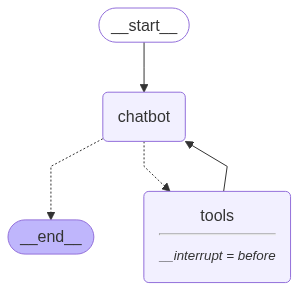

In [15]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

Define the **configurable** user session:

In [16]:
cfg_user_1 = {"configurable": {"thread_id": "1"}}

In [26]:
events = graph.stream(
    {"messages": [("user", "What is the weather in Sydney?")]}
    , cfg_user_1
    , stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the weather in Sydney?
================================== Ai Message ==================================

[{'type': 'text', 'text': "<thinking> The user's question is about the current weather in Sydney. I need to use the tavily_search_results_json tool to get the latest weather information. </thinking>\n"}, {'type': 'tool_use', 'name': 'tavily_search_results_json', 'input': {'query': 'current weather in Sydney'}, 'id': 'tooluse_efrXcyucQIWnfzpbzMmI7Q'}]
Tool Calls:
  tavily_search_results_json (tooluse_efrXcyucQIWnfzpbzMmI7Q)
 Call ID: tooluse_efrXcyucQIWnfzpbzMmI7Q
  Args:
    query: current weather in Sydney


To learn, let's inspect what is happening in the graph? what is the next node?

In [27]:
snapshot=graph.get_state(cfg_user_1)
snapshot.next

('tools',)

Check the original tool call

In [28]:
last_message = snapshot.values["messages"][-1]

print("Original tool call: ", last_message.tool_calls)
print("Original tool call Message ID: ", last_message.id)

Original tool call:  [{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Sydney'}, 'id': 'tooluse_efrXcyucQIWnfzpbzMmI7Q', 'type': 'tool_call'}]
Original tool call Message ID:  run--1c6fedcf-05b8-4552-822f-8f393ddcb586-0


Modify the `tools_calls mean`, message with the above id should be replace with the different message:

In [29]:
last_message.tool_calls[0]

{'name': 'tavily_search_results_json',
 'args': {'query': 'current weather in Sydney'},
 'id': 'tooluse_efrXcyucQIWnfzpbzMmI7Q',
 'type': 'tool_call'}

In [30]:
from langchain_core.messages import AIMessage

new_tool_call = last_message.tool_calls[0].copy()
new_tool_call["args"]['query'] = "What is the captial of Sri Lanka?"
new_tool_call

{'name': 'tavily_search_results_json',
 'args': {'query': 'What is the captial of Sri Lanka?'},
 'id': 'tooluse_efrXcyucQIWnfzpbzMmI7Q',
 'type': 'tool_call'}

In [31]:
last_message.content

[{'type': 'text',
  'text': "<thinking> The user's question is about the current weather in Sydney. I need to use the tavily_search_results_json tool to get the latest weather information. </thinking>\n"},
 {'type': 'tool_use',
  'name': 'tavily_search_results_json',
  'input': {'query': 'current weather in Sydney'},
  'id': 'tooluse_efrXcyucQIWnfzpbzMmI7Q'}]

Import to keep the same ID for replacement

In [32]:
new_message = AIMessage(
    content=last_message.content,
    tool_calls=[new_tool_call],
    id=last_message.id
)

new_tool_call

{'name': 'tavily_search_results_json',
 'args': {'query': 'What is the captial of Sri Lanka?'},
 'id': 'tooluse_efrXcyucQIWnfzpbzMmI7Q',
 'type': 'tool_call'}

update the state of the grap bu passing the above `new_message`. It is necessary to execute second line `tool_calls`.

In [33]:
graph.update_state(cfg_user_1, {"messages": [new_message]})
graph.get_state(cfg_user_1).values["messages"][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'What is the captial of Sri Lanka?'},
  'id': 'tooluse_efrXcyucQIWnfzpbzMmI7Q',
  'type': 'tool_call'}]

Continue the execution with the new message by updating the graph by `None`:

In [34]:
events = graph.stream(None, cfg_user_1, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================== Ai Message ==================================

[{'type': 'text', 'text': "<thinking> The user's question is about the current weather in Sydney. I need to use the tavily_search_results_json tool to get the latest weather information. </thinking>\n"}, {'type': 'tool_use', 'name': 'tavily_search_results_json', 'input': {'query': 'current weather in Sydney'}, 'id': 'tooluse_efrXcyucQIWnfzpbzMmI7Q'}]
Tool Calls:
  tavily_search_results_json (tooluse_efrXcyucQIWnfzpbzMmI7Q)
 Call ID: tooluse_efrXcyucQIWnfzpbzMmI7Q
  Args:
    query: What is the captial of Sri Lanka?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What is the capital of Sri Lanka? - Quora", "url": "https://www.quora.com/What-is-the-capital-of-Sri-Lanka-1", "content": "The capital of Sri Lanka is Sri Jayawardenepura Kotte. It is a historic capital of Sri Lanka, from the Kotte Kingdom (established 14th century). Sr